# Moment models fine-tune analysis | Mask test
> This notebook is the pre-analysis of moment models to select the cases used in the paper.

# RECORDATORIO 
1) Conseguir que compilen de nuevo
2) Enmascarar también en evaluación, no solo en training, majaretilla...

In [1]:
# Input parameters
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [2]:
#! pip install --no-deps ydata_profiling
#! pip install --no-deps dacite
#! pip install --no-deps multimethod
#! pip install --no-deps visions
#! pip install --no-deps wordcloud
#! pip install --no-deps imagehash
#! pip install --no-deps htmlmin

In [3]:
# Imports
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut
from dvats.imports import beep
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import ydata_profiling as ydp
import seaborn as sns

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7fbb462c5d20>

















In [4]:
import torch
torch.cuda.set_device(0)
#torch.cuda.set_device(1)

In [5]:
from fastai.losses import MSELossFlat
from dvats.encoder import MAELossFlat, EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE
import dvats.config as cfg_
import gc
import os

### Setting up Weight & Biases information

In [6]:
# User and project
entity = os.environ.get("WANDB_ENTITY")
project = os.environ.get("WANDB_PROJECT")
folder = entity+'/'+project+'/'

# Dataset
dataset = 'gtrends_kohls'
dataset_version = 'v2'

#dataset = 'S1'
#dataset_version = 'v8'

enc_artifact_dataset = folder + dataset + ':' + dataset_version

# Models
model_family = 'zeroshot-moment'
task = 'embedding'
enc_artifact_small_name = folder + model_family + '-small-' + task + ':v0'
enc_artifact_base_name  =  folder + model_family + '-base-' + task + ':v0'
enc_artifact_large_name = folder + model_family + '-large-' + task + ':v0'

In [7]:
enc_artifact_small_name

'mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0'

### Download dataset

In [8]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [9]:
print(df_artifact.name)
df = df_artifact.to_df()
display(df.head())
df.shape

gtrends_kohls:v2


wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.010417
2004-01-08,0.010417
2004-01-15,0.010417
2004-01-22,0.000000
2004-01-29,0.000000


(440, 1)

### Encoder Input

In [10]:
#enc_input, _ = SlidingWindow(window_len=17, stride=2, get_y=[])(df)
#enc_input.shape
enc_input = df

### Functions

In [11]:
def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def greater_than(lst, val):
    vals = []
    for x in lst:
        try:
            x = int(x)
            if (x > val): 
                vals.append(x)
        except:
            continue
    return vals
    #return [ x for x in lst if isinstance(x, int) and x > val]

In [12]:
def plot_with_multiple_secondary_y(df, primary_vars, secondary_vars, figsize=(12, 6)):
    """
    Plots multiple variables with different scales on primary and secondary y-axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - primary_vars (list): Variables to plot on the primary y-axis.
    - secondary_vars (list): Variables to plot on the secondary y-axis.
    - figsize (tuple): Size of the figure.

    Returns:
    - None: Displays the plot.
    """
    ax = df[primary_vars + secondary_vars].plot(
        secondary_y=secondary_vars, figsize=figsize
    )
    ax.set_title("Variables with Primary and Secondary Axes")
    plt.show()

In [13]:
def plot_correlation(profile, figsize=(8, 6)):
    correlation_matrix = profile.corr()
    # Crear el heatmap con seaborn
    plt.figure(figsize = figsize)  # Ajusta el tamaño si es necesario
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

### Common Fine-tune args

In [14]:
import dvats.config as cfg_
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [15]:
print(config['batch_size'])
print(config['r'])
print(config['analysis_mode'])

16
0.4
online


In [16]:
config['r'] = 1e-3 #1e-6
config['r']

0.001

In [17]:
config['norm_use_single_batch']

False

In [18]:
#! pip install tslearn

In [19]:
from tslearn.metrics import SoftDTWLossPyTorch

In [20]:
common_args = {
    "X": df,
    "stride": 1,
    "batch_size": config['batch_size'],
    "cpu": False,
    "to_numpy": False,
    "time_flag": True,
    "n_windows": None,
    "n_windows_percent": None,
    "shot": True,
    "eval_pre": True,
    "eval_post": True,
    "lr": config['r'], #use enc_run lr,
    "lr_scheduler_flag": True, # False
    "lr_scheduler_name": "cosine_with_restarts",
    "lr_scheduler_num_warmup_steps": 100, # None
    "window_sizes": [12],
    "full_dataset": True,
    "window_sizes_offset": 0.05,
    "windows_min_distance": 0, #int(np.ceil(1.5*enc_input.shape[0]/100)),
    "print_to_path": True,
    "print_both": False,
    "print_path": "./logs.txt",
    "print_mode": "a",
    "use_moment_masks": True,
    "mask_stateful": config['mask_stateful'],
    "mask_future": config['mask_future'],
    "mask_sync": config['mask_sync'],
    "analysis_mode": config['analysis_mode'],
    "use_wandb": config['use_wandb'],
    "norm_by_sample": config['norm_by_sample'],
    "norm_use_single_batch": config['norm_use_single_batch'],
    "show_plot": True,
    "metrics": [EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE],
    "metrics_args": [{'squared': False}, {'squared': True}, {}, {}],
    "metrics_names":["mse", "rmse", "mae", "smape"],
    "metrics_dict": None,
    #"criterion": torch.nn.MSELoss(),
    # Segmentation
    "criterion": SoftDTWLossPyTorch(gamma=5.0, normalize = True, dist_func = None),
    "mix_windows": True
}

In [21]:
common_args["windows_min_distance"]

0

### Cases execution function

In [22]:
from momentfm.utils.masking import Masking 

In [23]:
def clean_cuda():
    """
    Cleans CUDA memory by deleting variables, emptying the cache, and forcing garbage collection.

    Returns:
        None.
    """
    # Delete all tensors in CUDA to free memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    
    # Run garbage collection
    gc.collect()

    # Check available memory
    print("CUDA memory cleaned. Current allocated:", torch.cuda.memory_allocated() / 1e6, "MB")
    print("CUDA cached memory:", torch.cuda.memory_reserved() / 1e6, "MB")


    
def cases_loop(
    model, 
    n_epochs_list, 
    dataset_percents, 
    masked_percents, 
    n_sizes_list, 
    summarized = True, 
    do_beep = True, 
    verbose = 1,
    save = True,
    file_errors = "",
    file_results = ""
):
    mssg = ut.Mssg(verbose = verbose, level = -1)
    result_columns = [
        'model_size','n_epochs','dataset_percent','masked_percent','n_windows', 
        'time',
        'first_train_loss','first_mse','first_rmse','first_mae','first_smape', 
        'last_train_loss','last_mse','last_rmse','last_mae','last_smape'
    ]
    result_columns = result_columns if summarized else result_columns + ['losses','eval_results_pre','eval_results_post']
    results = pd.DataFrame(columns = result_columns)
    
    errors = pd.DataFrame(
        columns = [
            'model_size',
            'n_epochs',
            'dataset_percent',
            'masked_percent',
            'n_windows',
            'windows',
            'error'
        ]
    )
    model_backup = deepcopy(model)
    i = 0
    for n_epochs in n_epochs_list:
        for dataset_percent in dataset_percents:
            print(dataset_percent)
            for masked_percent in masked_percents:
                model.mask_generator = Masking(mask_ratio = masked_percent)
                for sizes in n_sizes_list:
                    print(f"--> epoch {n_epochs}, dataset_percent {dataset_percent}, mask {masked_percent}")
                    redmssg = f" sizes {sizes}"
                    redmssg = f"\033[91m{redmssg}\033[0m"
                    print(redmssg)

                    print(f"Cuda memmory allocated: {torch.cuda.memory_allocated()}")
                    model_case = deepcopy(model_backup)
                    case = {
                            'model_size': "small",
                            'n_epochs': n_epochs,
                            'dataset_percent': dataset_percent,
                            'masked_percent': masked_percent,
                            'n_windows': sizes,
                            'windows': None
                           }
                    result_dict = deepcopy(case)
                    error_dict = deepcopy(case)
                    error = False
                    print(1-dataset_percent)
                    torch.cuda.synchronize()
                    result = fine_tune(
                        enc_learn           = model_case,
                        window_mask_percent = masked_percent,
                        training_percent    = dataset_percent,
                        validation_percent  = 0.3,
                        num_epochs          = n_epochs,
                        n_window_sizes      = sizes,
                        verbose             = verbose,
                        register_errors     = True,
                        save_best_or_last   = True, # only available for moment,
                        #force_best_lr       = True,
                        **common_args    
                    )
                    common_args['print_mode']='a'

                    default_error = pd.DataFrame([{
                        'model_size': case['model_size'], 
                        'n_epochs': case['n_epochs'],
                        'dataset_percent': case['dataset_percent'],
                        'masked_percent': case['masked_percent'],
                        'n_windows': sizes,
                        'windows': "Unknown",
                        'error': 'Non registered error',
                        'window': "Unknown"
                    }])

                    try:
                        print("---- Returned internal errors ---")
                        internal_errors = result[10]
                        
                    except:
                        internal_errors = default_error
            
                    print("Check:", result[0])
                    if len(result[0]) > 0:
                    
                        result_dict.update({
                            'time'             : result[4],
                            'windows'          : result[8].cpu() if isinstance(result[8], torch.Tensor) else result[8],
                            'first_train_loss' : result[0][0][0].cpu().item() if torch.is_tensor(result[0][0][0]) else result[0][0][0],
                            'last_train_loss'  : result[0][-1][-1].cpu().item() if torch.is_tensor(result[0][-1][-1]) else result[0][-1][-1],
                            'best_epochs'       : result[9],
                            'train_losses'      : result[0][0],
                            'eval_pre'          : result[1],
                            'eval_post'         : result[2],
                            'full_result'       : result
                        })
                        if result[1] == {}:
                            result_dict.update({
                                'first_eval_loss'  : np.nan,
                                'first_mse'        : np.nan,
                                'first_rmse'       : np.nan,
                                'first_mae'        : np.nan
                            })
                        else:
                            print("N windows: ", len(result[8]))
                            print("Loss: ", result[1]['loss'])
                            result_dict.update({
                                'first_eval_loss'  : result[1]['loss'][-1].cpu().item() if torch.is_tensor(result[1]['loss']) else result[1]['loss'][-1],
                                'first_mse'        : result[1]['mse'][-1].cpu().item() if torch.is_tensor(result[1]['mse']) else result[1]['mse'][-1],    
                                'first_rmse'       : result[1]['rmse'][-1].cpu().item() if torch.is_tensor(result[1]['rmse']) else result[1]['rmse'][-1],
                                'first_mae'        : result[1]['mae'][-1].cpu().item() if torch.is_tensor(result[1]['mae']) else result[1]['mae'][-1],                                
                                'first_smape'      : result[1]['smape'].cpu().item() if torch.is_tensor(result[1]['smape']) else result[1]['smape']
                            })
                        if result[2] == {}:
                            result_dict.update({
                                'last_eval_loss'  : np.nan,
                                'last_mse'        : np.nan,
                                'last_rmse'       : np.nan,
                                'last_mae'        : np.nan
                            })
                        else:
                            result_dict.update({
                                'last_eval_loss'   : result[2]['loss'][-1].cpu().item() if torch.is_tensor(result[2]['loss'][-1]) else result[2]['loss'][-1],
                                'last_mse'         : result[2]['mse'][-1].cpu().item() if torch.is_tensor(result[2]['mse'][-1]) else result[2]['mse'][-1],
                                'last_rmse'        : result[2]['rmse'][-1].cpu().item() if torch.is_tensor(result[2]['rmse'][-1]) else result[2]['rmse'][-1],
                                'last_mae'         : result[2]['mae'][-1].cpu().item() if torch.is_tensor(result[2]['mae'][-1]) else result[2]['mae'][-1],
                                'last_smape'       : result[2]['smape'][-1].cpu().item() if torch.is_tensor(result[2]['smape'][-1]) else result[2]['smape'][-1]
                            })
                            
        
                        if not summarized:
                            result_dict.update({
                                'losses'           : [[v.cpu().item() if torch.is_tensor(v) else v for v in loss] for loss in result[0]],
                                'eval_results_pre' : {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[1].items()},
                                'eval_results_post': {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[2].items()},
                                })  
                        results = pd.concat([results, pd.DataFrame([result_dict])], ignore_index=True)
                    else:
                        print(f"Failed case | N Errors {errors.shape[0]} | N Results { results.shape[0] }")
                        # Attach possible errors
                        internal_errors['model_size'] = case['model_size']
                        internal_errors['n_epochs'] = case['n_epochs']
                        internal_errors['dataset_percent'] = case['dataset_percent']
                        internal_errors['masked_percent'] = case['masked_percent']
                        internal_errors['windows'] = [result[8]]*len(internal_errors)
                        print("--- Internal ---")
                        if (internal_errors.empty):
                            print("Returned errors empty")
                            internal_errors = default_error
                        display(internal_errors)
                        errors = pd.concat([errors, internal_errors])
                        print("--- Concatenated ---")
                        display(errors)
                        print(f"Failed case | N Errors {errors.shape[0]} | N Results { results.shape[0] } ")
                    if not error: mssg.print_error(f" case {case} | time: {result[4]}")
                    before = torch.cuda.memory_allocated()
                    model_case = None
                    gc.collect()
                    torch.cuda.empty_cache()
                    display(results)
                    clean_cuda()
                    if do_beep:
                        beep(1)
                    mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {masked_percent}, sizes {sizes} -->")
                if save:
                    mssg.print(f"Update results into {file_results}")
                    results.to_csv(file_results, index = False, header = True)
                    mssg.print(f"Update errors into {file_errors}")
                    errors.to_csv(file_errors, index = False, header = True)
                if do_beep:
                    beep(2)
                    beep(2)
                mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {masked_percent} -->")
            if do_beep:
                beep(3)
                beep(3)
                beep(3)
            mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}-->")
        if do_beep:
            beep(4)
            beep(4)
            beep(4)
            beep(4)
        mssg.print(f"epoch {n_epochs}-->")
    if do_beep:
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
    model_backup = None
    gc.collect()
    torch.cuda.empty_cache()
    return results, errors

# Analysis

## Defining full reasonable values

The following parameters are modified within the fine-tuning:
- `n_epochs_list` is used to set up the number of epochs used in the training step.
- `dataset_percents` is used to select the percentage of the dataset used for each case fine-tuning.
- `masked_percents` is used to select the  percentage of the training dataset we want to mask for the model to fill it up.
- `sizes` is used to select the number of window sizes we want to use for the fine-tuning.

In [24]:
n_epochs_list     = [5, 10, 20]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp. entrenar con todo el dataset.
masked_percents = [0.25, 0.5, 0.75]
sizes             = [1, 5]
total_cases_small = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")

Total cases: 72


### Moment-Small
Getting the results for moment small.

#### Download the model

In [25]:
already_computed_small = False
#file_errors_small  = 'errors_small_29012025_1.csv'
#file_results_small = 'results_small_29012025_1.csv'
#file_errors_small  = 'errors_small_03022025_2.csv'
#file_results_small = 'results_small_03022025_2.csv'
#file_errors_small  = 'errors_small_06022025_1.csv'
#file_results_small = 'results_small_06022025_1.csv'
file_errors_small  = 'errors_small_07022025_1.csv'
file_results_small = 'results_small_07022025_1.csv'
file_errors_small  = 'errors_small_10022025_1.csv'
file_results_small = 'results_small_10022025_1.csv'
file_errors_small  = 'errors_small_11022025_2.csv'
file_results_small = 'results_small_11022025_2.csv'
file_errors_small  = 'errors_small_11022025_3.csv'
file_results_small = 'results_small_11022025_3.csv'
file_errors_small  = 'errors_small_11022025_4.csv'
file_results_small = 'results_small_11022025_4.csv'
file_errors_small  = 'errors_small_12022025_1.csv'
file_results_small = 'results_small_12022025_1.csv'
file_errors_small  = 'errors_small_12022025_2.csv'
file_results_small = 'results_small_12022025_2.csv'
file_errors_small  = 'errors_small_14022025_2.csv' #e-4
file_results_small = 'results_small_14022025_2.csv'
file_errors_small  = 'errors_small_14022025_3.csv' # e-3
file_results_small = 'results_small_14022025_3.csv'
file_errors_small  = 'errors_small_17022025_3.csv' # lr_find --- no conseguido # lr_optimizer
file_results_small = 'results_small_17022025_3.csv'

file_errors_small  = 'errors_small_25022025_3.csv' 
file_results_small = 'results_small_25022025_3.csv'

file_errors_small  = 'errors_small_26022025_1' 
file_results_small = 'results_small_26022025_1'
file_errors_small  = 'errors_small_03032025_1' 
file_results_small = 'results_small_03032025_1'

file_results_small = 'results_small_dtw_segmentation_1'
file_errors_small = 'errors_small_dtw_segmentation_2'
file_errors_small = file_errors_small+dataset+version+".csv"
file_results_small = file_results_small+dataset+version+".csv"

In [26]:
print(file_results_small)
print(file_errors_small)

results_small_dtw_segmentation_1gtrends_kohlsv2.csv
errors_small_dtw_segmentation_2gtrends_kohlsv2.csv


In [27]:
print("Getting small artifact: ", enc_artifact_small_name)
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

Getting small artifact:  mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0
zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [28]:
moment_small.head.linear.out_features

8

### Specific parameters

In [29]:
n_epochs_list_small    = [20]
dataset_percents_small = [0.15, 0.2,0.25, 0.3]
masked_percents_small  = [0.25, 0.5, 0.75]
sizes_small            = [1, 2, 4, 6, 8, 10]
#sizes_small            = [6, 8, 10]
total_cases_small      = len(n_epochs_list_small)*len(dataset_percents_small)*len(masked_percents_small)*len(sizes_small)
print(f"Total cases: {total_cases_small}")

Total cases: 72


### Execute!

In [30]:
? moment_small

Signature:        moment_small(*args, **kwargs) -> momentfm.data.base.TimeseriesOutputs
Type:            MOMENTPipeline
String form:    
MOMENTPipeline(
           (normalizer): RevIN()
           (tokenizer): Patching()
           (patch_embedding): PatchEmbed <...> pout(p=0.1, inplace=False)
           (linear): Linear(in_features=512, out_features=8, bias=True)
           )
           )
File:            /usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py
Docstring:       <no docstring>
Class docstring:
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.c

In [31]:
results_small      = None
errors_small       = None
already_computed_small  = True
if already_computed_small:
    results_small = pd.read_csv(
        file_results_small, 
        index_col= None, 
        header   =0
    )
    errors_small  = pd.read_csv(
        file_errors_small, 
        index_col = None, 
        header    =0
    )
else:
    results_small, errors_small = cases_loop(
        model             = moment_small, 
        n_epochs_list     = n_epochs_list_small, 
        dataset_percents  = dataset_percents_small, 
        masked_percents = masked_percents_small, 
        n_sizes_list      = sizes_small, 
        verbose           = 1,
        summarized        = True,
        save              = True,
        file_errors       = file_errors_small,
        file_results      = file_results_small
    )
    #already_computed_small = True

Observaciones:
- El número de épocas más pequeño a partir de los 

In [32]:
#results_small = pd.read_csv(file_results_small, index_col=None, header=0)
#errors_small  = pd.read_csv(file_errors_small, index_col=None, header=0)
print(errors_small.shape)
print(results_small.shape)

(0, 7)
(72, 24)


In [33]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_small)}")
display(errors_small.head())
print(f"Total results: {len(results_small)}")
display(results_small.head())

----- ERRORS -----
Total error cases: 0


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,windows,error


Total results: 72


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,45.371627,0.05507,0.084263,0.007223,0.050187,...,0.046363,0.14262,[12],[17],"[0.0550696256395895, 0.005906084137677681, 0.004606146598234773, 0.004813798310351558, 0.005367987971112598, 0.004488728867727332, 0.00476673427328933, 0.004817005952645559, 0.005007813313568477, 0.004195404930214863, 0.0045912343775853515, 0.004936751029163133, 0.004231047976645641, 0.004739596719446126, 0.004160436452366412, 0.004425843239005189, 0.0042632553886505775, 0.004222606010443997, 0.0037003268662374467, 0.0038409720291383564, 0.004350977600552142]","{'loss': [0.0550696256395895], 'mse': [0.08426340660102133], 'rmse': [0.0072233216044560785], 'mae': [0.05018662035557603], 'smape': [0.15552181776596463]}","{'loss': [0.04475618644210044], 'mse': [0.07565897896323093], 'rmse': [0.005866676308358899], 'mae': [0.04636320100773957], 'smape': [0.14262026641863557]}","([[0.0550696256395895, 0.005906084137677681, 0.004606146598234773, 0.004813798310351558, 0.005367987971112598, 0.004488728867727332, 0.00476673427328933, 0.004817005952645559, 0.005007813313568477, 0.004195404930214863, 0.0045912343775853515, 0.004936751029163133, 0.004231047976645641, 0.004739596719446126, 0.004160436452366412, 0.004425843239005189, 0.0042632553886505775, 0.004222606010443997, 0.0037003268662374467, 0.0038409720291383564, 0.004350977600552142]], {'loss': [0.0550696256395895], 'mse': [0.08426340660102133], 'rmse': [0.0072233216044560785], 'mae': [0.05018662035557603], 'sma...",0.05507,0.044756
1,small,20,0.15,0.25,2,43.809639,0.05507,0.084263,0.007223,0.050187,...,0.046363,0.14262,[12],[17],"[0.0550696256395895, 0.005906084137677681, 0.004606146598234773, 0.004813798310351558, 0.005367987971112598, 0.004488728867727332, 0.00476673427328933, 0.004817005952645559, 0.005007813313568477, 0.004195404930214863, 0.0045912343775853515, 0.004936751029163133, 0.004231047976645641, 0.004739596719446126, 0.004160436452366412, 0.004425843239005189, 0.0042632553886505775, 0.004222606010443997, 0.0037003268662374467, 0.0038409720291383564, 0.004350977600552142]","{'loss': [0.0550696256395895], 'mse': [0.08426340660102133], 'rmse': [0.0072233216044560785], 'mae': [0.05018662035557603], 'smape': [0.15552181776596463]}","{'loss': [0.04475618644210044], 'mse': [0.07565897896323093], 'rmse': [0.005866676308358899], 'mae': [0.04636320100773957], 'smape': [0.14262026641863557]}","([[0.0550696256395895, 0.005906084137677681, 0.004606146598234773, 0.004813798310351558, 0.005367987971112598, 0.004488728867727332, 0.00476673427328933, 0.004817005952645559, 0.005007813313568477, 0.004195404930214863, 0.0045912343775853515, 0.004936751029163133, 0.004231047976645641, 0.004739596719446126, 0.004160436452366412, 0.004425843239005189, 0.0042632553886505775, 0.004222606010443997, 0.0037003268662374467, 0.0038409720291383564, 0.004350977600552142]], {'loss': [0.0550696256395895], 'mse': [0.08426340660102133], 'rmse': [0.0072233216044560785], 'mae': [0.05018662035557603], 'sma...",0.05507,0.044756
2,small,20,0.15,0.25,4,42.401660,0.05507,0.084263,0.007223,0.050187,...,0.046363,0.14262,[12],[17],"[0.0550696256395895, 0.005906084137677681, 0.004606146598234773, 0.004813798310351558, 0.005367987971112598, 0.004488728867727332, 0.00476673427328933, 0.004817005952645559, 0.005007813313568477, 0.004195404930214863, 0.0045912343775853515, 0.004936751029163133, 0.004231047976645641, 0.004739596719446126, 0.004160436452366412, 0.004425843239005189, 0.0042632553886505775, 0.004222606010443997, 0.0037003268662374467, 0.0038409720291383564, 0.004350977600552142]","{'loss': [0.0550696256395895], 'mse': [0.08426340660102133], 'rmse': [0.0072233216044560785], 'mae': [0.05018662035557603], 'smape': [0.15552181776596463]}","{'loss': [0.04475618644210044], 'mse': [0.

In [34]:
results_small["best_epochs"]

0     [17]
1     [17]
2     [17]
3     [17]
4     [17]
      ... 
67    [19]
68    [19]
69    [19]
70    [19]
71    [19]
Name: best_epochs, Length: 72, dtype: object

#### Checking the errors
Checking the error cases to see if they can be fixed within the code for the future

In [35]:
#if already_computed_small:
#    display(results_small['windows'].drop_duplicates())

In [36]:
#if (already_computed_small):
#    errors_small['n_epochs'] = pd.to_numeric(errors_small['n_epochs'], errors='coerce').astype('Int64')
#    errors_small['n_windows'] = pd.to_numeric(errors_small['n_windows'], errors='coerce').astype('Int64')
#    errors_small['masked_percent'] = pd.to_numeric(errors_small['masked_percent'], errors='coerce').astype(float)
#    errors_small['error'] = errors_small['error'].astype(str)
#    print(results_small.dtypes)
#    results_small['model_size'] = results_small['model_size'].astype(pd.StringDtype())
#    print("--- Second check ---")
#    print(results_small.dtypes)

In [37]:
#if already_computed_small:
#    display(results_small['windows'].drop_duplicates())

In [38]:
#if errors_small.shape[0] > 0:
#    error_small_window_sizes = list(errors_small['window'].drop_duplicates())
#    display(error_small_window_sizes)

In [39]:
#if errors_small.shape[0] > 0:
#    error_small_mssg =errors_small['error'].astype(str).drop_duplicates()
#    display(error_small_mssg)

We see two failures to check within the failures:
1) Windows do no respect the requested distance between sepparated windows (only one with ne next). TODO: check
2) This dataset needs windows bigger than 4 for MOMENT - Small. => 
    => We need:

   - A minimum and maximum variate allowing to ask for windows sizes inside an interval
   - Control within the windows sizes. If we all like this log table, we can save an unique variate (not saving the windows part) just to check if a window has already failed with this error so it does not execute again.
   - ¿Buen TFG un SQL de gestión de errores para DeepVATS? -> Hablar con Víctor

First valid window:

In [40]:
#small_windows = results_small['windows'].drop_duplicates()
#print(small_windows.shape)
#display(small_windows)

In [41]:
#filtered_windows = small_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
#filtered_windows

A futuros, se observa que, cuando analicemos este dataset, deberemos:
- Usar ventanas mayores que 5, preferiblemente, >= 8.
- Corregir la función de ventanas para que indique en un warning y en una variable el número de ventanas devuelto realmente. Gestionar para que si no se ha devuelto el número de ventanas esperado, se corte el loop ahí en lugar de repetir los mismos expserimentos. 

#### Time analysis

In [42]:
total_time = results_small['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

4586.659371852875 seconds
76.44432286421458 minutes
1.2740720477369096 hours


<Axes: >

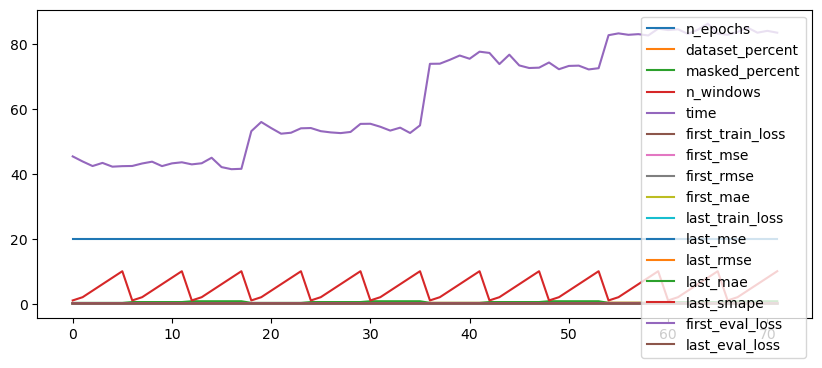

In [43]:
results_small.plot(figsize = (10,4))

In [44]:
#df_time_analysis_small = results_small[[
#    "time", 
#    "n_epochs", 
#    "dataset_percent", 
#    "masked_percent", 
#    "n_windows", 
#    "last_eval_loss", 
#    "last_mse"
#]]
#df_time_analysis_small.plot(figsize = (10,4))

In [46]:
#plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time", "n_windows"], ["last_eval_loss", "dataset_percent", "masked_percent", 'last_mse'])

In [47]:
#profile_small_df = df_time_analysis_small.copy(deep = True)

In [48]:
#profile_small.to_notebook_iframe()

In [49]:
#profile_small_df.head()

In [50]:
#print(profile_small_df.dtypes)

In [51]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
#profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
#profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir masked_percent a float, manejando posibles errores
#profile_small_df['masked_percent'] = pd.to_numeric(profile_small_df['masked_percent'], errors='coerce').astype(float)

In [52]:
#profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

In [53]:
 #plot_correlation(profile_small_df)

A nivel de tiempo, se observa que:

- Apenas afecta el enmascarado, con una correlación negativa con el last loss. Lo mismo ocurre con el n_epochs
- Más tiempo parece hacer crecer el last_loss
- Lo que más influye es el porcentaje de dataset utilizado para el fine_tuning. Más dataset parece hacer empeorar por alguna razón
- El last loss está bastante relacionado con el tiempo dedicado al fine-tuning, como es de esperar. Pero. La correlación es positiva => más last loss => más tiempo.
- El número de ventanas parece ir en contra de bajar el loss.. quizá porque va de la mano del número de ventanas.


### Loss & metrics analysis

A nivel de losses, se observa (sin tener en cuenta mse, rmse, mae, smape): 
- Muy poca relación con el enmascarado, cosa que de primeras sorprende
- Mucha relación con el % de dataset utilizado en el fine-tuning
Por lo tanto,
    - vamos a filtrar el dataset para tener tiempos menores a 8 segundos
y buenos losses.
    - Veamos a partir de qué momento se obtienen unos losses razonables  en %.

In [54]:
results_small.columns

Index(['model_size', 'n_epochs', 'dataset_percent', 'masked_percent',
       'n_windows', 'time', 'first_train_loss', 'first_mse', 'first_rmse',
       'first_mae', 'first_smape', 'last_train_loss', 'last_mse', 'last_rmse',
       'last_mae', 'last_smape', 'windows', 'best_epochs', 'train_losses',
       'eval_pre', 'eval_post', 'full_result', 'first_eval_loss',
       'last_eval_loss'],
      dtype='object')

In [55]:
df_loss_small = results_small[[
    "time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", 
    "first_eval_loss", "last_eval_loss", "first_mse", "last_mse"
]].copy()

In [56]:
#display(df_loss_small[["first_eval_loss", "last_eval_loss"]])
#display(df_loss_small[["first_mse", "last_mse"]])

In [57]:
#df_loss_small["loss_percent"] = (df_loss_small['first_eval_loss']-df_loss_small['last_eval_loss'])*100/(df_loss_small['first_eval_loss'])
#df_loss_small["loss_percent"].plot()
#df_loss_small["mse_percent"] = (df_loss_small['first_mse']-df_loss_small['last_mse'])*100/(df_loss_small['first_mse'])
#df_loss_small["mse_percent"].plot()

In [58]:
#df_loss_small[df_loss_small["loss_percent"] > 0]

In [59]:
#df_loss_small[df_loss_small["time"] < 8]["loss_percent"].plot()
#df_loss_small[df_loss_small["time"] < 8]["mse_percent"].plot()

In [60]:
# Filtrar filas donde "time" es menor a 8 segundos
#df_loss_small_best_cases = df_loss_small[df_loss_small["time"] < 8].copy()

#print("--------------------- Train -----------------")
# Filtrar los 5 mejores loss_percents
#display(df_loss_small_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
#display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
#print("---------------------- Eval ------------------")
# Filtrar los 5 mejores loss_percents
#display(df_loss_small_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
#display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])

In [61]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
#profile_small_df = df_loss_small[['time', 'n_epochs', 'dataset_percent', 'masked_percent', 'n_windows', 'loss_train_percent', 'mse_percent']].copy()
#profile_small_df.dtypes

In [62]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
#profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
#profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')
# Convertir masked_percent a float, manejando posibles errores
#profile_small_df['masked_percent'] = pd.to_numeric(profile_small_df['masked_percent'], errors='coerce').astype(float)

In [63]:
#profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_loss_small'", explorative=True)
#plot_correlation(profile_small_df)

#### What if I focus on 0.25 dataset percent?

In [64]:
#profile_small_df_2 = df_time_analysis_small[df_time_analysis_small['dataset_percent'] == 0.25].drop(columns=['dataset_percent', 'time']).copy()

In [65]:
#fprofile_small_df_2.dtypesf

In [66]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
#profile_small_df_2['n_epochs'] = pd.to_numeric(profile_small_df_2['n_epochs'], errors='coerce').astype('Int64')
#profile_small_df_2['n_windows'] = pd.to_numeric(profile_small_df_2['n_windows'], errors='coerce').astype('Int64')
# Convertir masked_percent a float, manejando posibles errores
#profile_small_df_2['masked_percent'] = pd.to_numeric(profile_small_df_2['masked_percent'], errors='coerce').astype(float)

In [67]:
#profile_small_2 = ydp.ProfileReport(profile_small_df_2, title="Pandas Profiling Report for 'df_time_analysis_small' for < 0.25 dataset percent", explorative=True)
#plot_correlation(profile_small_df_2)

* Correlación inversa entre masked percent y last loss * => Aumentar masked percent baja last_loss
* => Es parte de lo que queremos!

In [68]:
#! ls errors*

In [69]:
clean_cuda()

CUDA memory cleaned. Current allocated: 0.0 MB
CUDA cached memory: 0.0 MB


In [70]:
#before = torch.cuda.memory_allocated()
#print(before)
#moment_small.to('cpu')
#for param in moment_small.parameters():
#    param.to('cpu')
#after = torch.cuda.memory_allocated()
#print(after)
#print("Mejorado: ", after-before)

## Moment-base

### Download the model

In [71]:
print("Getting base artifact: ", enc_artifact_base_name)
enc_artifact_base  = wandb_api.artifact(enc_artifact_base_name, type='learner')
moment_base  = enc_artifact_base.to_obj()

Getting base artifact:  mi-santamaria/deepvats/zeroshot-moment-base-embedding:v0


wandb: Downloading large artifact zeroshot-moment-base-embedding:v0, 432.97MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3


### Select parameters

In [72]:
#total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
#print(f"Total cases: {total_cases_small}")

n_epochs_list_base= [20]
dataset_percents_base  = [0.15, 0.2, 0.3]
masked_percents_base = [ 0.25, 0.5, 0.75]
sizes_base             = [1, 5]

#n_epochs_list_base= [5, 10, 20]
#dataset_percents_base  = [0.25, 0.5]
#masked_percents_base = [ 0.25, 0.5, 0.75]
#sizes_base             = [1, 5, 10]
#total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(masked_percents_base)*len(sizes)
#print(f"Total cases: {total_cases_base}")
#expected_time = total_time*total_cases_base/total_cases_small
#print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

### Configure files and wether already computed or not

In [73]:
clean_cuda()

CUDA memory cleaned. Current allocated: 0.0 MB
CUDA cached memory: 0.0 MB


In [74]:
already_computed_base = False
results_base = None
errors_base = None
file_errors_base = 'errors_base_24012025_1.csv'
file_results_base = 'results_base_24012025_1.csv'
file_errors_base = 'errors_base_24022025_1.csv'
file_results_base = 'results_base_24022025_1.csv'
file_errors_base = 'errors_base_26022025_1'
file_results_base = 'results_base_26022025_1'
file_results_base = 'results_base_dtw_segmentation_1'
file_errors_base = 'errors_base_dtw_segmentation_2'

file_errors_base = file_errors_base + dataset + version+'.csv'
file_results_base = file_results_base + dataset + version+'.csv'

### Execute cases

In [75]:
results_base = None
errors_base = None
if already_computed_base:
    results_base = pd.read_csv(file_results_base, index_col=None, header=0)
    errors_base = pd.read_csv(file_errors_base, index_col=None, header=0)
else:
    results_base, errors_base = cases_loop(
        model             = moment_base, 
        n_epochs_list     = n_epochs_list_base, 
        dataset_percents  = dataset_percents_base, 
        masked_percents = masked_percents_base,
        n_sizes_list      = sizes_base, 
        summarized        = True,
        verbose           = 8,
        save = True,
        file_errors =file_errors_base,
        file_results = file_results_base
    )
    results_base.to_csv(file_results_base, index=False, header=True)
    errors_base.to_csv(file_errors_base, index=False, header=True)
    already_computed_base = True

0.15
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 1
Cuda memmory allocated: 0
0.85
Initialize Windowed Dataset


100% 8/8 [00:09<00:00,  1.13s/it]
100% 80/80 [00:48<00:00,  1.64it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]]
N windows:  1
Loss:  [0.04802770001697354]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 49.06394577026367


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468


CUDA memory cleaned. Current allocated: 472.565248 MB
CUDA cached memory: 513.80224 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 5
Cuda memmory allocated: 472565248
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 80/80 [00:46<00:00,  1.73it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]]
N windows:  1
Loss:  [0.048157972953049466]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 46.56700015068054


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468


CUDA memory cleaned. Current allocated: 927.566848 MB
CUDA cached memory: 987.758592 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 1
Cuda memmory allocated: 927566848
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 80/80 [00:45<00:00,  1.77it/s]
100% 8/8 [00:06<00:00,  1.32it/s]

---- Returned internal errors ---
Check: [[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]]
N windows:  1
Loss:  [0.05124305207573343]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 45.55477714538574


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 1383.092736 MB
CUDA cached memory: 1482.686464 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 5
Cuda memmory allocated: 1383092736
0.85
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.33it/s]
100% 80/80 [00:46<00:00,  1.73it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]]
N windows:  1
Loss:  [0.05124305207573343]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 46.735695600509644


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 1838.094336 MB
CUDA cached memory: 1956.642816 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 1
Cuda memmory allocated: 1838094336
0.85
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.32it/s]
100% 80/80 [00:45<00:00,  1.75it/s]
100% 8/8 [00:06<00:00,  1.33it/s]

---- Returned internal errors ---
Check: [[0.05642123002326116, 0.005305006394337397, 0.004622909487807192, 0.004147466053836979, 0.005218387901550159, 0.005074181601230521, 0.005382176619605161, 0.005257589138636831, 0.005255419862805866, 0.004733777117507998, 0.005607238235825207, 0.004615200581611134, 0.004508282530878205, 0.004435731687408406, 0.004852534628298599, 0.004550723657303024, 0.004281769011868164, 0.005276766445604153, 0.004811812294065021, 0.003960045760322828, 0.0048073949219542556]]
N windows:  1
Loss:  [0.05642123002326116]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 46.0758421421051


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 2293.620224 MB
CUDA cached memory: 2430.599168 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 5
Cuda memmory allocated: 2293620224
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 80/80 [00:45<00:00,  1.75it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05642123002326116, 0.005305006394337397, 0.004622909487807192, 0.004147466053836979, 0.005218387901550159, 0.005074181601230521, 0.005382176619605161, 0.005257589138636831, 0.005255419862805866, 0.004733777117507998, 0.005607238235825207, 0.004615200581611134, 0.004508282530878205, 0.004435731687408406, 0.004852534628298599, 0.004550723657303024, 0.004281769011868164, 0.005276766445604153, 0.004811812294065021, 0.003960045760322828, 0.0048073949219542556]]
N windows:  1
Loss:  [0.05642123002326116]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 45.85986876487732


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 2749.146112 MB
CUDA cached memory: 2925.52704 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75 -->


[8]  [ cases_loop ] epoch 20, dataset_percent 0.15-->
0.2
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 1
Cuda memmory allocated: 2749146112
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 100/100 [00:57<00:00,  1.73it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.048157972953049466, 0.00259711699327454, 0.002595258643850684, 0.0027108869515359403, 0.0025161422207020225, 0.0027092733012977987, 0.0028750394412782043, 0.0024854047107510267, 0.002457927056821063, 0.0023715294781140985, 0.002769796649226919, 0.0024030993808992207, 0.0023433796246536075, 0.0025758622912690045, 0.0024870579421985895, 0.0025181471020914612, 0.0023631061951164154, 0.002699860924622044, 0.002341904817149043, 0.0022941197152249516, 0.0025712324830237778]]
N windows:  1
Loss:  [0.048157972953049466]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 57.97102618217468


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 3204.147712 MB
CUDA cached memory: 3399.483392 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 5
Cuda memmory allocated: 3204147712
0.8
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.30it/s]
100% 100/100 [00:57<00:00,  1.73it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.048157972953049466, 0.00259711699327454, 0.002595258643850684, 0.0027108869515359403, 0.0025161422207020225, 0.0027092733012977987, 0.0028750394412782043, 0.0024854047107510267, 0.002457927056821063, 0.0023715294781140985, 0.002769796649226919, 0.0024030993808992207, 0.0023433796246536075, 0.0025758622912690045, 0.0024870579421985895, 0.0025181471020914612, 0.0023631061951164154, 0.002699860924622044, 0.002341904817149043, 0.0022941197152249516, 0.0025712324830237778]]
N windows:  1
Loss:  [0.048157972953049466]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 57.98909306526184


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 3659.6736 MB
CUDA cached memory: 3873.439744 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 1
Cuda memmory allocated: 3659673600
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 100/100 [00:56<00:00,  1.77it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05124305207573343, 0.0026208925584796814, 0.002524220891064033, 0.0026379482063930483, 0.002594392345054075, 0.0028602716745808722, 0.003279186267172918, 0.002498483000090346, 0.002840093767736107, 0.002602788002695888, 0.002747573336819187, 0.002436561818467453, 0.0025536133092828096, 0.002396112272981554, 0.0025801977259106933, 0.0027504930389113725, 0.0024513183801900596, 0.002749012678395957, 0.0023975255084224046, 0.0023530363338068127, 0.002865472971461713]]
N windows:  1
Loss:  [0.05124305207573343]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 56.836872816085815


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 4115.199488 MB
CUDA cached memory: 4368.367616 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 5
Cuda memmory allocated: 4115199488
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 100/100 [00:56<00:00,  1.76it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05124305207573343, 0.0026208925584796814, 0.002524220891064033, 0.0026379482063930483, 0.002594392345054075, 0.0028602716745808722, 0.003279186267172918, 0.002498483000090346, 0.002840093767736107, 0.002602788002695888, 0.002747573336819187, 0.002436561818467453, 0.0025536133092828096, 0.002396112272981554, 0.0025801977259106933, 0.0027504930389113725, 0.0024513183801900596, 0.002749012678395957, 0.0023975255084224046, 0.0023530363338068127, 0.002865472971461713]]
N windows:  1
Loss:  [0.05124305207573343]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 56.94798159599304


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 4570.201088 MB
CUDA cached memory: 4842.323968 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 1
Cuda memmory allocated: 4570201088
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 100/100 [00:57<00:00,  1.74it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05642123002326116, 0.003327726206043735, 0.002836374205071479, 0.002820958330994472, 0.0027754007431212814, 0.0036047601432073863, 0.0034675973176490514, 0.0026961572584696114, 0.0029864732932765037, 0.0029886112781241534, 0.003497988119488582, 0.0030394131899811327, 0.0035405422968324274, 0.0029060295259114356, 0.002995328640099615, 0.0027766145998612047, 0.002684123336803168, 0.0031252191110979766, 0.0030272844363935293, 0.002747756411554292, 0.0034155415603891017]]
N windows:  1
Loss:  [0.05642123002326116]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 57.909809589385986


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 5025.726976 MB
CUDA cached memory: 5316.28032 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 5
Cuda memmory allocated: 5025726976
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 100/100 [00:56<00:00,  1.76it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.05642123002326116, 0.003327726206043735, 0.002836374205071479, 0.002820958330994472, 0.0027754007431212814, 0.0036047601432073863, 0.0034675973176490514, 0.0026961572584696114, 0.0029864732932765037, 0.0029886112781241534, 0.003497988119488582, 0.0030394131899811327, 0.0035405422968324274, 0.0029060295259114356, 0.002995328640099615, 0.0027766145998612047, 0.002684123336803168, 0.0031252191110979766, 0.0030272844363935293, 0.002747756411554292, 0.0034155415603891017]]
N windows:  1
Loss:  [0.05642123002326116]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 57.17955946922302


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 5481.252864 MB
CUDA cached memory: 5811.208192 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75 -->


[8]  [ cases_loop ] epoch 20, dataset_percent 0.2-->
0.3
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 1
Cuda memmory allocated: 5481252864
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 160/160 [01:29<00:00,  1.78it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.048157972953049466, 0.0047226330534613226, 0.004328991919464897, 0.004522781120613217, 0.004262239057425177, 0.0042146279229200445, 0.004084961201442638, 0.004161658271186752, 0.004020248852611985, 0.004347170986875426, 0.004142582005442819, 0.004499180631682975, 0.0038693476490152534, 0.004202039526717272, 0.003902538461261429, 0.004029064864880638, 0.004249272522429237, 0.003942062765418086, 0.0038630506169283763, 0.003978071519668447, 0.004005064496595878]]
N windows:  1
Loss:  [0.048157972953049466]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 90.19184494018555


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 5936.254464 MB
CUDA cached memory: 6287.261696 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 5
Cuda memmory allocated: 5936254464
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 160/160 [01:30<00:00,  1.78it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.048157972953049466, 0.0047226330534613226, 0.004328991919464897, 0.004522781120613217, 0.004262239057425177, 0.0042146279229200445, 0.004084961201442638, 0.004161658271186752, 0.004020248852611985, 0.004347170986875426, 0.004142582005442819, 0.004499180631682975, 0.0038693476490152534, 0.004202039526717272, 0.003902538461261429, 0.004029064864880638, 0.004249272522429237, 0.003942062765418086, 0.0038630506169283763, 0.003978071519668447, 0.004005064496595878]]
N windows:  1
Loss:  [0.048157972953049466]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 90.410897731781


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 6391.780352 MB
CUDA cached memory: 6761.218048 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 1
Cuda memmory allocated: 6391780352
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 160/160 [01:30<00:00,  1.76it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05124305207573343, 0.005014599344576709, 0.004419064644025639, 0.0047948863211786374, 0.0043363022996345535, 0.004302765155443922, 0.004391849084640853, 0.0042201898868370336, 0.004257574688381283, 0.004810646307305433, 0.004307207193050999, 0.00468388722583768, 0.0041807818597590085, 0.004550528352410765, 0.004155581231316319, 0.004198648312012665, 0.004739887266623555, 0.0038664131789118983, 0.004028821458632592, 0.004349761591583956, 0.004289307540602749]]
N windows:  1
Loss:  [0.05124305207573343]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 91.03589797019958


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 6847.30624 MB
CUDA cached memory: 7256.14592 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 5
Cuda memmory allocated: 6847306240
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 160/160 [01:29<00:00,  1.78it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.05124305207573343, 0.005014599344576709, 0.004419064644025639, 0.0047948863211786374, 0.0043363022996345535, 0.004302765155443922, 0.004391849084640853, 0.0042201898868370336, 0.004257574688381283, 0.004810646307305433, 0.004307207193050999, 0.00468388722583768, 0.0041807818597590085, 0.004550528352410765, 0.004155581231316319, 0.004198648312012665, 0.004739887266623555, 0.0038664131789118983, 0.004028821458632592, 0.004349761591583956, 0.004289307540602749]]
N windows:  1
Loss:  [0.05124305207573343]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 89.9459137916565


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 7302.30784 MB
CUDA cached memory: 7730.102272 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 1
Cuda memmory allocated: 7302307840
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 160/160 [01:28<00:00,  1.82it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.05642123002326116, 0.005793701013317332, 0.004603637178661302, 0.005012646164686885, 0.005334900175512303, 0.005068494680017466, 0.004945183678501053, 0.004372236577182775, 0.004986021976947086, 0.005980388192256214, 0.004523434785369318, 0.00540338559585507, 0.004713043537776684, 0.004931631221552379, 0.004507970810664119, 0.004853237933275523, 0.005076022309367545, 0.004631939300452359, 0.00459302877789014, 0.004524297772150021, 0.005108585755806416]]
N windows:  1
Loss:  [0.05642123002326116]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 88.456711769104


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 7757.833728 MB
CUDA cached memory: 8204.058624 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 5
Cuda memmory allocated: 7757833728
0.7
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.27it/s]
100% 160/160 [01:28<00:00,  1.81it/s]
100% 8/8 [00:06<00:00,  1.32it/s]

---- Returned internal errors ---
Check: [[0.05642123002326116, 0.005793701013317332, 0.004603637178661302, 0.005012646164686885, 0.005334900175512303, 0.005068494680017466, 0.004945183678501053, 0.004372236577182775, 0.004986021976947086, 0.005980388192256214, 0.004523434785369318, 0.00540338559585507, 0.004713043537776684, 0.004931631221552379, 0.004507970810664119, 0.004853237933275523, 0.005076022309367545, 0.004631939300452359, 0.00459302877789014, 0.004524297772150021, 0.005108585755806416]]
N windows:  1
Loss:  [0.05642123002326116]
[8]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 88.87314176559448


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

CUDA memory cleaned. Current allocated: 8213.359616 MB
CUDA cached memory: 8698.986496 MB


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 5 -->
[8]  [ cases_loop ] Update results into results_base_dtw_segmentation_1gtrends_kohlsv2.csv
[8]  [ cases_loop ] Update errors into errors_base_dtw_segmentation_2gtrends_kohlsv2.csv


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75 -->


[8]  [ cases_loop ] epoch 20, dataset_percent 0.3-->


[8]  [ cases_loop ] epoch 20-->


In [76]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_base)}")
display(errors_base.head())
print(f"Total results: {len(results_base)}")
display(results_base.head())

----- ERRORS -----
Total error cases: 0


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,windows,error


Total results: 18


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.063946,0.048028,0.078591,0.006296,0.045406,...,0.045865,0.141629,[12],[17],"[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 'smape': [0.14080101161169356]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.04802770001697354, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.04802770001697354], 'mse': [0.07859110959300648], 'rmse': [0.0062959575776010265], 'mae': [0.04540647175316968], 's...",0.048028,0.043468
1,small,20,0.15,0.25,5,46.567000,0.048158,0.078716,0.006313,0.045554,...,0.045865,0.141629,[12],[17],"[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]","{'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 'smape': [0.1415616096165383]}","{'loss': [0.04346786496171262], 'mse': [0.07466575151906163], 'rmse': [0.005697071636247321], 'mae': [0.0458652303084608], 'smape': [0.1416293093574837]}","([[0.048157972953049466, 0.004199100570986047, 0.004257837877958082, 0.004146207240410149, 0.004166573722613975, 0.004033303455798887, 0.004370172537164763, 0.004219420428853482, 0.004446123915840872, 0.0040954567230073735, 0.004066295761731453, 0.003797505851252936, 0.004051909483678173, 0.004166796032222919, 0.0038512000683113, 0.0036833047852269374, 0.003879015945130959, 0.004129653760173824, 0.0036218457462382503, 0.0036678787364508025, 0.0038220759961404838]], {'loss': [0.048157972953049466], 'mse': [0.07871556178504004], 'rmse': [0.006313183802612313], 'mae': [0.0455544899440994], 's...",0.048158,0.043468
2,small,20,0.15,0.50,1,45.554777,0.051243,0.081434,0.006721,0.047168,...,0.046811,0.144221,[12],[15],"[0.05124305207573343, 0.004254043036780786, 0.004906463364022784, 0.004296357175917365, 0.004547499003820121, 0.004196588197373785, 0.004512787047133315, 0.004510051221586764, 0.004467880535230506, 0.004059302489622496, 0.004482996606384404, 0.00406872715393547, 0.004000096312665846, 0.004236577296978794, 0.004221765928377863, 0.003960834445024375, 0.003620451083406806, 0.0044900141801917925, 0.0036389784872881137, 0.003786333058087621, 0.0040088459572871216]","{'loss': [0.05124305207573343], 'mse': [0.08143352607267967], 'rmse': [0.006720854844787072], 'mae': [0.04716823382441662], 'smape': [0.14622959714532197]}","{'loss': [0.04689613819937222], 'ms

### Checking the errors

In [77]:
len(results_base)

18

In [78]:
error_base_window_sizes = list(errors_base['windows'].drop_duplicates())
error_base_window_sizes

[]

In [79]:
error_base_mssg = errors_base['error'].astype(str).drop_duplicates()
error_base_mssg

Series([], Name: error, dtype: object)

In [80]:
base_windows = results_base['windows'].drop_duplicates()
filtered_windows_base = base_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows_base

0    [12]
Name: windows, dtype: object

#### Time analysis

In [81]:
#df_time_analysis_base = results_base[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "last_train_loss", "last_mse"]]

In [82]:
#plot_with_multiple_secondary_y(df_time_analysis_base, ["n_epochs", "time", "n_windows"], ["last_train_loss", "dataset_percent", "masked_percent", "last_mse"])

In [83]:
#profile_base_df = df_time_analysis_base.copy(deep = True)
#profile_base = ydp.ProfileReport(profile_base_df, title="Pandas Profiling Report for 'df_time_analysis_base'", explorative=True)

In [84]:
#plot_correlation(profile_base_df)

#### Loss & metrics analysis

In [85]:
#df_loss_base = results_base[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()
#df_loss_base["loss_percent"] = (df_loss_base['first_train_loss']-df_loss_base['first_train_loss'])*100/(df_loss_base['first_train_loss'])
#df_loss_base["loss_percent"].plot()
#df_loss_base["mse_percent"] = (df_loss_base['first_mse']-df_loss_base['last_mse'])*100/(df_loss_base['first_mse'])
#df_loss_base["mse_percent"].plot()

In [86]:
#df_loss_base[df_loss_base["time"] < 8]["loss_percent"].plot()
#df_loss_base[df_loss_base["time"] < 8]["mse_percent"].plot()

In [87]:
#df_loss_base[df_loss_base["time"] < 20]

In [88]:
# Filtrar filas donde "time" es menor a 8 segundos
#df_loss_base_best_cases = df_loss_base[df_loss_base["time"] < 8].copy()

#print("---- Mejoras en el entrenamiento ----")
# Filtrar los 5 mejores loss_percents
#display(df_loss_base_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
#display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
#print("---- Mejoras en la validación  ----")
# Filtrar los 5 mejores loss_percents
#display(df_loss_base_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
#display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('mse_percent', ascending = False)[:5])

In [89]:
#print(torch.cuda.memory_allocated())
#gc.collect()
#torch.cuda.empty_cache()
#print(torch.cuda.memory_allocated())

## Moment-large

### Download de large model

In [90]:
already_computed_large = False
file_errors_large = 'errors_large_03022025_1.csv'
file_results_large = 'results_large_03022025_1.csv'
file_errors_large = 'errors_large_24022025_1.csv'
file_results_large = 'results_large_24022025_1.csv'
file_results_large = 'results_large_dtw_segmentation_1'
file_errors_large = 'errors_large_dtw_segmentation_2'
file_errors_large = file_errors_small+dataset+version+".csv"
file_results_large = file_results_small+dataset+version+".csv"

In [91]:
if not already_computed_large:
    print("Getting large artifact: ", enc_artifact_large_name)
    enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
    print(enc_artifact_large.name)
    moment_large = enc_artifact_large.to_obj()
    print(count_parameters(moment_large))

Getting large artifact:  mi-santamaria/deepvats/zeroshot-moment-large-embedding:v0
zeroshot-moment-large-embedding:v0


wandb: Downloading large artifact zeroshot-moment-large-embedding:v0, 1321.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.9


341248520


In [92]:
#total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
#print(f"Total cases: {total_cases_small}")
#total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(masked_percents_base)*len(sizes)
#print(f"Total cases: {total_cases_base}")
#expected_time = total_time*total_cases_base/total_cases_small
#print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

n_epochs_list_large     = [20]
dataset_percents_large  = [0.15, 0.2, 0.3] # No tendría sentido porque sería como hacer lo mismo que con mvp
masked_percents_large = [0.25, 0.5, 0.75]
sizes_large             = [1, 5, 10]
print(f"Total cases: {len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)}")

Total cases: 72


In [94]:
clean_cuda()

CUDA memory cleaned. Current allocated: 8213.359616 MB
CUDA cached memory: 8698.986496 MB


In [95]:
results_large = None
errors_large = None
if already_computed_large:
    results_large = pd.read_csv(file_results_large, index_col=None, header=0)
    errors_large = pd.read_csv(file_errors_large, index_col=None, header=0)
else:
    results_large, errors_large = cases_loop(
        model             = moment_large, 
        n_epochs_list     = n_epochs_list_large,
        dataset_percents  = dataset_percents_large, 
        masked_percents = masked_percents_large, 
        n_sizes_list      = sizes_large, 
        summarized        = True,
        save              = True,
        file_errors       =  file_errors_large,
        file_results      = file_results_large
    )
    already_computed_large = True

0.15
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 1
Cuda memmory allocated: 8213359616
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 80/80 [00:49<00:00,  1.63it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 49.926106691360474


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565


CUDA memory cleaned. Current allocated: 9675.38176 MB
CUDA cached memory: 10152.312832 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 5
Cuda memmory allocated: 9675381760
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 80/80 [00:46<00:00,  1.71it/s]
100% 8/8 [00:05<00:00,  1.37it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 47.29036259651184


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565


CUDA memory cleaned. Current allocated: 11137.403904 MB
CUDA cached memory: 11614.027776 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 5 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 10
Cuda memmory allocated: 11137403904
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 80/80 [00:46<00:00,  1.73it/s]
100% 8/8 [00:06<00:00,  1.31it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 46.89914512634277


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 12599.426048 MB
CUDA cached memory: 13075.74272 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 1
Cuda memmory allocated: 12599426048
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 80/80 [00:47<00:00,  1.68it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.0036536920961225405, 0.0035986988514196128, 0.00362972506263759, 0.0038843527727294713, 0.004095897689694539, 0.004234566498780623, 0.003891669402946718, 0.003752140881260857, 0.004107537657546345, 0.0035699113432201557, 0.003781534978770651, 0.004014528276456986, 0.0036342829480418004, 0.003755559795536101, 0.0035022578595089726, 0.0040963391729746945, 0.004028848517918959, 0.0037454017947311513, 0.0035544664788176306, 0.0035408340700087138]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 47.99225831031799


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 14061.448192 MB
CUDA cached memory: 14537.457664 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 5
Cuda memmory allocated: 14061448192
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 80/80 [00:47<00:00,  1.68it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.0036536920961225405, 0.0035986988514196128, 0.00362972506263759, 0.0038843527727294713, 0.004095897689694539, 0.004234566498780623, 0.003891669402946718, 0.003752140881260857, 0.004107537657546345, 0.0035699113432201557, 0.003781534978770651, 0.004014528276456986, 0.0036342829480418004, 0.003755559795536101, 0.0035022578595089726, 0.0040963391729746945, 0.004028848517918959, 0.0037454017947311513, 0.0035544664788176306, 0.0035408340700087138]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 48.34932732582092


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 15523.470336 MB
CUDA cached memory: 16001.26976 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 5 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 10
Cuda memmory allocated: 15523470336
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 80/80 [00:46<00:00,  1.70it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.0036536920961225405, 0.0035986988514196128, 0.00362972506263759, 0.0038843527727294713, 0.004095897689694539, 0.004234566498780623, 0.003891669402946718, 0.003752140881260857, 0.004107537657546345, 0.0035699113432201557, 0.003781534978770651, 0.004014528276456986, 0.0036342829480418004, 0.003755559795536101, 0.0035022578595089726, 0.0040963391729746945, 0.004028848517918959, 0.0037454017947311513, 0.0035544664788176306, 0.0035408340700087138]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 47.45253658294678


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 16985.49248 MB
CUDA cached memory: 17462.984704 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 1
Cuda memmory allocated: 16985492480
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.37it/s]
100% 80/80 [00:46<00:00,  1.71it/s]
100% 8/8 [00:06<00:00,  1.32it/s]

---- Returned internal errors ---
Check: [[0.05540997546631843, 0.004173632551101036, 0.004360354505479336, 0.004531888123892713, 0.005292882662615739, 0.004770644794916734, 0.005083415286208037, 0.004820582282263786, 0.004088473629963119, 0.004787146179296542, 0.00376808312284993, 0.004342239481047727, 0.004709726345026866, 0.004892806900897995, 0.004718909789517056, 0.003982748574344441, 0.00495050929748686, 0.0040732699853833765, 0.00437848213914549, 0.0038181350246304646, 0.004304094618419185]]
N windows:  1
Loss:  [0.05540997546631843]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 47.18096399307251


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 18447.514624 MB
CUDA cached memory: 18924.699648 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 5
Cuda memmory allocated: 18447514624
0.85
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 80/80 [00:46<00:00,  1.72it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.05540997546631843, 0.004173632551101036, 0.004360354505479336, 0.004531888123892713, 0.005292882662615739, 0.004770644794916734, 0.005083415286208037, 0.004820582282263786, 0.004088473629963119, 0.004787146179296542, 0.00376808312284993, 0.004342239481047727, 0.004709726345026866, 0.004892806900897995, 0.004718909789517056, 0.003982748574344441, 0.00495050929748686, 0.0040732699853833765, 0.00437848213914549, 0.0038181350246304646, 0.004304094618419185]]
N windows:  1
Loss:  [0.05540997546631843]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 46.91059398651123


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 19909.536768 MB
CUDA cached memory: 20386.414592 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 5 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 10
Cuda memmory allocated: 19909536768
0.85
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.33it/s]
100% 80/80 [00:46<00:00,  1.73it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.05540997546631843, 0.004173632551101036, 0.004360354505479336, 0.004531888123892713, 0.005292882662615739, 0.004770644794916734, 0.005083415286208037, 0.004820582282263786, 0.004088473629963119, 0.004787146179296542, 0.00376808312284993, 0.004342239481047727, 0.004709726345026866, 0.004892806900897995, 0.004718909789517056, 0.003982748574344441, 0.00495050929748686, 0.0040732699853833765, 0.00437848213914549, 0.0038181350246304646, 0.004304094618419185]]
N windows:  1
Loss:  [0.05540997546631843]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 46.84114861488342


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 21371.558912 MB
CUDA cached memory: 21848.129536 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15-->
0.2
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 1
Cuda memmory allocated: 21371558912
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 100/100 [00:58<00:00,  1.71it/s]
100% 8/8 [00:05<00:00,  1.37it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.002372738963458687, 0.002329836750868708, 0.0023825627809856086, 0.0024708516080863773, 0.0023621632833965124, 0.002375146228587255, 0.0024335514230187983, 0.0023826345684938134, 0.0023943907057400794, 0.0022956878936383875, 0.002250296424608678, 0.00222872284357436, 0.0025062127446290106, 0.0023694815463386476, 0.0023044311441481114, 0.0023345495108515026, 0.002350218512583524, 0.002247567824088037, 0.002336901577655226, 0.0023185411468148232]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 58.835261821746826


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 22833.581056 MB
CUDA cached memory: 23309.84448 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 5
Cuda memmory allocated: 22833581056
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.37it/s]
100% 100/100 [00:58<00:00,  1.72it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.002372738963458687, 0.002329836750868708, 0.0023825627809856086, 0.0024708516080863773, 0.0023621632833965124, 0.002375146228587255, 0.0024335514230187983, 0.0023826345684938134, 0.0023943907057400794, 0.0022956878936383875, 0.002250296424608678, 0.00222872284357436, 0.0025062127446290106, 0.0023694815463386476, 0.0023044311441481114, 0.0023345495108515026, 0.002350218512583524, 0.002247567824088037, 0.002336901577655226, 0.0023185411468148232]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 58.92142128944397


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 24295.6032 MB
CUDA cached memory: 24771.559424 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 5 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 10
Cuda memmory allocated: 24295603200
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.37it/s]
100% 100/100 [00:58<00:00,  1.72it/s]
100% 8/8 [00:06<00:00,  1.31it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.002372738963458687, 0.002329836750868708, 0.0023825627809856086, 0.0024708516080863773, 0.0023621632833965124, 0.002375146228587255, 0.0024335514230187983, 0.0023826345684938134, 0.0023943907057400794, 0.0022956878936383875, 0.002250296424608678, 0.00222872284357436, 0.0025062127446290106, 0.0023694815463386476, 0.0023044311441481114, 0.0023345495108515026, 0.002350218512583524, 0.002247567824088037, 0.002336901577655226, 0.0023185411468148232]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 58.96896767616272


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 25757.625344 MB
CUDA cached memory: 26235.37152 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 1
Cuda memmory allocated: 25757625344
0.8
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.33it/s]
100% 100/100 [00:59<00:00,  1.67it/s]
100% 8/8 [00:06<00:00,  1.31it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.0023962027044035494, 0.0025030712131410837, 0.0027087779017165303, 0.002559025667142123, 0.0028083743643946947, 0.0025053201650734993, 0.002741593652172014, 0.0027011390018742533, 0.002550260646967217, 0.0024674351676367222, 0.00233733705827035, 0.002458692464279011, 0.002729951712535694, 0.002456006535794586, 0.002443499368382618, 0.00245169487898238, 0.0025042577122803777, 0.002367235458223149, 0.0025104993721470235, 0.002286592859309167]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 60.26986002922058


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 27219.647488 MB
CUDA cached memory: 27697.086464 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 5
Cuda memmory allocated: 27219647488
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.34it/s]
100% 100/100 [00:57<00:00,  1.72it/s]
100% 8/8 [00:05<00:00,  1.37it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.0023962027044035494, 0.0025030712131410837, 0.0027087779017165303, 0.002559025667142123, 0.0028083743643946947, 0.0025053201650734993, 0.002741593652172014, 0.0027011390018742533, 0.002550260646967217, 0.0024674351676367222, 0.00233733705827035, 0.002458692464279011, 0.002729951712535694, 0.002456006535794586, 0.002443499368382618, 0.00245169487898238, 0.0025042577122803777, 0.002367235458223149, 0.0025104993721470235, 0.002286592859309167]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 58.45491552352905


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 28681.669632 MB
CUDA cached memory: 29158.801408 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 5 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 10
Cuda memmory allocated: 28681669632
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.37it/s]
100% 100/100 [00:57<00:00,  1.74it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.0023962027044035494, 0.0025030712131410837, 0.0027087779017165303, 0.002559025667142123, 0.0028083743643946947, 0.0025053201650734993, 0.002741593652172014, 0.0027011390018742533, 0.002550260646967217, 0.0024674351676367222, 0.00233733705827035, 0.002458692464279011, 0.002729951712535694, 0.002456006535794586, 0.002443499368382618, 0.00245169487898238, 0.0025042577122803777, 0.002367235458223149, 0.0025104993721470235, 0.002286592859309167]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 58.05193018913269


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 30143.691776 MB
CUDA cached memory: 30620.516352 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 1
Cuda memmory allocated: 30143691776
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 100/100 [00:59<00:00,  1.68it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.05540997546631843, 0.00279548418475315, 0.0030085019068792464, 0.0032322591345291586, 0.003177251311717555, 0.0034394162881653755, 0.0027953309123404323, 0.002694228512700647, 0.003020243329228833, 0.0030159940477460625, 0.002785162866348401, 0.0024935508146882055, 0.003232049645157531, 0.003488871629815549, 0.0028136219189036638, 0.0028931855282280593, 0.0027304078219458463, 0.002924697124399245, 0.002645961131202057, 0.0031145412242040036, 0.0026663154421839863]]
N windows:  1
Loss:  [0.05540997546631843]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 60.19171667098999


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 31605.71392 MB
CUDA cached memory: 32082.231296 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 5
Cuda memmory allocated: 31605713920
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.35it/s]
100% 100/100 [00:59<00:00,  1.69it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.05540997546631843, 0.00279548418475315, 0.0030085019068792464, 0.0032322591345291586, 0.003177251311717555, 0.0034394162881653755, 0.0027953309123404323, 0.002694228512700647, 0.003020243329228833, 0.0030159940477460625, 0.002785162866348401, 0.0024935508146882055, 0.003232049645157531, 0.003488871629815549, 0.0028136219189036638, 0.0028931855282280593, 0.0027304078219458463, 0.002924697124399245, 0.002645961131202057, 0.0031145412242040036, 0.0026663154421839863]]
N windows:  1
Loss:  [0.05540997546631843]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 59.806604862213135


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 33067.736064 MB
CUDA cached memory: 33543.94624 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 5 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 10
Cuda memmory allocated: 33067736064
0.8
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.37it/s]
100% 100/100 [00:58<00:00,  1.72it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.05540997546631843, 0.00279548418475315, 0.0030085019068792464, 0.0032322591345291586, 0.003177251311717555, 0.0034394162881653755, 0.0027953309123404323, 0.002694228512700647, 0.003020243329228833, 0.0030159940477460625, 0.002785162866348401, 0.0024935508146882055, 0.003232049645157531, 0.003488871629815549, 0.0028136219189036638, 0.0028931855282280593, 0.0027304078219458463, 0.002924697124399245, 0.002645961131202057, 0.0031145412242040036, 0.0026663154421839863]]
N windows:  1
Loss:  [0.05540997546631843]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 58.763638973236084


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 34529.758208 MB
CUDA cached memory: 35005.661184 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2-->
0.3
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 1
Cuda memmory allocated: 34529758208
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 160/160 [01:30<00:00,  1.78it/s]
100% 8/8 [00:05<00:00,  1.34it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.0037406502015073784, 0.0039704344380879775, 0.003799262678512605, 0.0038395248229790013, 0.003929132770281285, 0.004122850572457537, 0.0039446186274290085, 0.003956356733397115, 0.0037865926751692314, 0.004040921758132754, 0.003986101546615828, 0.003812809649389237, 0.0038105855746835005, 0.004086586010089377, 0.003745096950297011, 0.0037854678121220786, 0.003812900435150368, 0.003814433435763931, 0.003830834597465582, 0.004042637548991479]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 91.00767946243286


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 35991.780352 MB
CUDA cached memory: 36469.47328 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 5
Cuda memmory allocated: 35991780352
0.7
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.32it/s]
100% 160/160 [01:30<00:00,  1.77it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.0037406502015073784, 0.0039704344380879775, 0.003799262678512605, 0.0038395248229790013, 0.003929132770281285, 0.004122850572457537, 0.0039446186274290085, 0.003956356733397115, 0.0037865926751692314, 0.004040921758132754, 0.003986101546615828, 0.003812809649389237, 0.0038105855746835005, 0.004086586010089377, 0.003745096950297011, 0.0037854678121220786, 0.003812900435150368, 0.003814433435763931, 0.003830834597465582, 0.004042637548991479]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 91.17977690696716


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 37453.802496 MB
CUDA cached memory: 37931.188224 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 5 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 10
Cuda memmory allocated: 37453802496
0.7
Initialize Windowed Dataset


100% 8/8 [00:06<00:00,  1.33it/s]
100% 160/160 [01:30<00:00,  1.77it/s]
100% 8/8 [00:05<00:00,  1.35it/s]

---- Returned internal errors ---
Check: [[0.04355892325111199, 0.0037406502015073784, 0.0039704344380879775, 0.003799262678512605, 0.0038395248229790013, 0.003929132770281285, 0.004122850572457537, 0.0039446186274290085, 0.003956356733397115, 0.0037865926751692314, 0.004040921758132754, 0.003986101546615828, 0.003812809649389237, 0.0038105855746835005, 0.004086586010089377, 0.003745096950297011, 0.0037854678121220786, 0.003812900435150368, 0.003814433435763931, 0.003830834597465582, 0.004042637548991479]]
N windows:  1
Loss:  [0.04355892325111199]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 91.16800570487976


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 38915.82464 MB
CUDA cached memory: 39392.903168 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_large_dtw_segmentation_1
[1]  [ cases_loop ] Update errors into errors_large_dtw_segmentation_2


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 1
Cuda memmory allocated: 38915824640
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 160/160 [01:31<00:00,  1.75it/s]
100% 8/8 [00:05<00:00,  1.37it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.00394620786755695, 0.004364952943433309, 0.0045000779173278715, 0.0043269598463666625, 0.004580422119033756, 0.004501028648519423, 0.004012877005152404, 0.0042760736505442765, 0.004115285188163398, 0.0039461550550186075, 0.004256818596331868, 0.003927155175915686, 0.0037993184741935693, 0.004548228975181701, 0.003810994756349828, 0.0040855125298548955, 0.004252125323546352, 0.0038657942386635114, 0.004295901682780823, 0.004334797351475572]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 91.65408325195312


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 40377.846784 MB
CUDA cached memory: 40854.618112 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 5
Cuda memmory allocated: 40377846784
0.7
Initialize Windowed Dataset


100% 8/8 [00:05<00:00,  1.36it/s]
100% 160/160 [01:31<00:00,  1.76it/s]
100% 8/8 [00:05<00:00,  1.36it/s]

---- Returned internal errors ---
Check: [[0.04782305935805198, 0.00394620786755695, 0.004364952943433309, 0.0045000779173278715, 0.0043269598463666625, 0.004580422119033756, 0.004501028648519423, 0.004012877005152404, 0.0042760736505442765, 0.004115285188163398, 0.0039461550550186075, 0.004256818596331868, 0.003927155175915686, 0.0037993184741935693, 0.004548228975181701, 0.003810994756349828, 0.0040855125298548955, 0.004252125323546352, 0.0038657942386635114, 0.004295901682780823, 0.004334797351475572]]
N windows:  1
Loss:  [0.04782305935805198]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 92.00091242790222


,model_size,n_epochs,dataset_percent,masked_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post,full_result,first_eval_loss,last_eval_loss
0,small,20,0.15,0.25,1,49.926107,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
1,small,20,0.15,0.25,5,47.290363,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356492309307214], 'mse': [0.07468776037592734], 'rmse': [0.005709635501479813], 'mae': [0.04622714364639491], 'smape': [0.1427566775000914]}","([[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]], {'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.0465312266860865...",0.043559,0.043565
2,small,20,0.15,0.25,10,46.899145,0.043559,0.074682,0.005709,0.046531,...,0.046227,0.142757,[12],[9],"[0.04355892325111199, 0.0036772689782083035, 0.0034098432006430812, 0.0035399644475546665, 0.0034106334351236, 0.00365805922774598, 0.00356202018156182, 0.0037295902802725323, 0.0035031457009608857, 0.003635976063378621, 0.0033406876464141533, 0.0036142645112704486, 0.003671291342470795, 0.0035170723422197625, 0.0036372481044963934, 0.0035573741406551562, 0.003866151033435017, 0.0034532388890511356, 0.0037352307117544115, 0.0035968054726254195, 0.0034957019961439073]","{'loss': [0.04355892325111199], 'mse': [0.07468238813606488], 'rmse': [0.005709407564460303], 'mae': [0.04653122668608653], 'smape': [0.1442284382363716]}","{'loss': [0.04356

CUDA memory cleaned. Current allocated: 41839.868928 MB
CUDA cached memory: 42316.333056 MB


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 5 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 10
Cuda memmory allocated: 41839868928
0.7
Initialize Windowed Dataset


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.45 GiB of which 15.50 MiB is free. Process 2489 has 6.77 GiB memory in use. Process 1483244 has 40.67 GiB memory in use. Of the allocated memory 40.03 GiB is allocated by PyTorch, and 446.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [100]:
errors_large

In [96]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())
print("------------------")

----- ERRORS -----


TypeError: object of type 'NoneType' has no len()

In [98]:
print("----- ERRORS -----")
#print(f"Total error cases: {len(errors_large)}")
#display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())

----- ERRORS -----


TypeError: object of type 'NoneType' has no len()

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_large.to('cpu')
for param in moment_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
gc.collect()
print("Mejorado: ", after-before)

#### Errors analysis

In [ ]:
if len(errors_large) > 0:
    error_large_window_sizes = list(errors_large['window'].drop_duplicates())
    error_large_window_sizes

In [ ]:
try:
    error_large_mssg = errors_large['error'].astype(str).drop_duplcates()
    display(error_large_mssg)
except Exception as e:
    print(e)

In [ ]:
large_windows = results_large['windows'].drop_duplicates()
print(large_windows.shape)
display(large_windows)

In [ ]:
filtered_windows_large = large_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
display(filtered_windows_large)

#### Time analysis

In [ ]:
df_time_analysis_large = results_large[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "last_train_loss", 'last_mse']]
df_time_analysis_large.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_large, ["n_epochs", "time", "n_windows"], ["last_train_loss", 'last_mse', "dataset_percent", "masked_percent"])

In [ ]:
profile_large_df = df_time_analysis_large.copy(deep = True)
profile_large = ydp.ProfileReport(profile_large_df, title = "Pandas Profiling Report for 'df_time_analysis_large'", explorative = True)
#profile_large.to_notebook_iframe()

In [ ]:
plot_correlation(profile_large_df)

In [ ]:
df_loss_large = results_large[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()

In [ ]:
df_loss_large["loss_train_percent"] = (df_loss_large['first_train_loss']-df_loss_large['last_train_loss'])*100/(df_loss_large['first_train_loss'])
df_loss_large["mse_percent"] = (df_loss_large['first_mse']-df_loss_large['last_mse'])*100/(df_loss_large['first_mse'])
df_loss_large["loss_train_percent"].plot()
df_loss_large["mse_percent"].plot()

In [ ]:
df_loss_large_best_cases = df_loss_large[df_loss_large["time"] < 8].copy()
display(df_loss_large_best_cases)
print("--- train ---")
display(df_loss_large_best_cases[df_loss_large_best_cases["loss_train_percent"] > 0])
print("--- eval ---")
display(df_loss_large_best_cases[df_loss_large_best_cases["mse_percent"] > 0])
display(df_loss_large_best_cases)

In [ ]:
display(df_loss_large_best_cases.sort_values('loss_train_percent', ascending = False))

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
gc.collect()
torch.cuda.empty_cache()
after = torch.cuda.memory_allocated()
print(after)
print(after-before)

In [ ]:
gpu_tensors = []
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            gpu_tensors.append(obj)
    except ReferenceError:
        continue # Omitir los objetos que ya han sido recolectados
print(len(gpu_tensors))

#### Loss & metrics analysis

In [ ]:
#| export
if verbose > 0: print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    os._exit(00)

# Memory checks

In [ ]:
snapshot = torch.cuda.memory_snapshot()
gpu_tensors = [obj['tensor'] for obj in snapshot if 'tensor' in obj]
for tensor_info in gpu_tensors:
    print(f"Size: {tensor_info['size']}, Device: {tensor_info['device']}, Data type: {tensor_info['dtype']}")
print(gpu_tensors)

In [ ]:
object_types = set()
for obj in snapshot:
    for key in obj.keys():
        object_types.add(key)
print("Tipos de objetos encontrados en el snapshot:")
for obj_type in sorted(object_types):
    print(obj_type)
heavier_obj = None
for obj in snapshot:
    if heavier_obj is None or obj['total_size'] > heavier_obj['total_size']: heavier_obj = obj
print(heavier_obj)

In [ ]:
before = torch.cuda.memory_allocated()
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_base.to('cpu')
for param in moment_base.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_large.to('cpu')
for param in moment_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
error_small_window_sizes = list(errors_small_hoy['windows'].drop_duplicates())
error_small_window_sizes

In [ ]:
errors_small_hoy

In [ ]:
total_time = results_small_hoy['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

In [ ]:
df_time_analysis_small = results_small_hoy[["time", "n_epochs", "dataset_percent", "masked_percent", "last_train_loss", 'last_mse']]
df_time_analysis_small.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time"], ["last_train_loss", "dataset_percent", "masked_percent", 'last_mse'])

In [ ]:
profile_small_df = df_time_analysis_small.copy(deep = True)

In [ ]:
print("--- Cases ---")
print("--- Number of epochs ---")
print(profile_small_df["n_epochs"].unique())
print("--- Dataset percent ---")
print(profile_small_df["dataset_percent"].unique())
print("--- Dataset masked percent ---")
print(profile_small_df["masked_percent"].unique())

In [ ]:
profile_small_df.head()

In [ ]:
print(profile_small_df.dtypes)

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
#profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir masked_percent a float, manejando posibles errores
profile_small_df['masked_percent'] = pd.to_numeric(profile_small_df['masked_percent'], errors='coerce').astype(float)

In [ ]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

In [ ]:
 plot_correlation(profile_small_df)